# 1. Import Libraries

In [81]:
import pandas as pd
import plotly.express as px
import numpy as np
import xgboost as xgb
import pickle
import json
import sklearn
import feature_engine
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import kendalltau, pearsonr
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

# 2. Data Loading

In [3]:
df = pd.read_csv('samarinda_fix_clean.csv')

In [4]:
df.head(10)

,harga,lokasi,luas_bangunan,luas_tanah,sertifikat,furnish,kamar_tidur,kamar_mandi,listrik,kamar_tidur_art,kamar_mandi_art
0,2800000,Sungai Pinang,218.0,180.0,SHM,Semi-furnished,3,3,4400.0,1,1
1,900000,Sungai Pinang,250.0,300.0,SHM,Non-furnished,4,2,1300.0,0,0
2,11000000,Samarinda Kota,350.0,558.0,SHM,Non-furnished,10,6,3500.0,0,0
3,1850000,Samarinda Seberang,90.0,200.0,SHM,Fully-furnished,3,2,1300.0,0,0
4,900000,Samarinda Kota,90.0,200.0,SHM,Fully-furnished,4,2,1300.0,0,0
5,1600000,Samarinda Ulu,220.0,135.0,SHM,Non-furnished,4,3,1300.0,0,0
6,2200000,Samarinda Kota,140.0,184.0,SHM,Non-furnished,5,2,2200.0,1,1
7,950000,Sambutan,128.0,225.0,HGB,Non-furnished,3,2,1300.0,0,0
8,875000,Samarinda Utara,57.0,200.0,SHM,Non-furnished,3,1,450.0,0,0
9,600000,Samarinda Ilir,115.0,235.0,SHM,Non-furnished,2,1,1300.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   harga            444 non-null    int64  
 1   lokasi           444 non-null    object 
 2   luas_bangunan    444 non-null    float64
 3   luas_tanah       444 non-null    float64
 4   sertifikat       444 non-null    object 
 5   furnish          444 non-null    object 
 6   kamar_tidur      444 non-null    int64  
 7   kamar_mandi      444 non-null    int64  
 8   listrik          444 non-null    float64
 9   kamar_tidur_art  444 non-null    int64  
 10  kamar_mandi_art  444 non-null    int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 38.3+ KB


In [8]:
(df['kamar_mandi_art']==0).sum()

432

In [10]:
df_copy = df.copy()

In [11]:
df = df.drop(columns=['kamar_mandi_art'])

In [13]:
df = df.rename(columns={'kamar_tidur_art':'kamar_pembantu'})

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   harga           444 non-null    int64  
 1   lokasi          444 non-null    object 
 2   luas_bangunan   444 non-null    float64
 3   luas_tanah      444 non-null    float64
 4   sertifikat      444 non-null    object 
 5   furnish         444 non-null    object 
 6   kamar_tidur     444 non-null    int64  
 7   kamar_mandi     444 non-null    int64  
 8   listrik         444 non-null    float64
 9   kamar_pembantu  444 non-null    int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 34.8+ KB


# 3. Exploratory Data Analysis

## 3.1. Cardinality Check

In [15]:
pd.set_option('display.max_colwidth', None)

cat_cols = (df.select_dtypes(exclude=['int64', 'float64']).columns)

listItem = []
for col in cat_cols:
    listItem.append([col, df[col].nunique()])

cardinal_df = pd.DataFrame(listItem, columns=['nama kolom', 'jumlah nilai unique'])
cardinal_df

,nama kolom,jumlah nilai unique
0,lokasi,11
1,sertifikat,4
2,furnish,3


dataset memilki 3 kolom kategorik yang ketiganya tidak memiliki high cardinality, sehingga bisa diterapkan OneHotEncoding

In [87]:
df['lokasi'].unique()

array(['  Sungai Pinang', '  Samarinda Kota', '  Samarinda Seberang',
       '  Samarinda Ulu', '  Sambutan', '  Samarinda Utara',
       '  Samarinda Ilir', '  Sungai Kunjang', '  Samarinda Kunjang',
       '  Loa Janan Ilir', '  Palaran'], dtype=object)

# 4. Feature Engineering

## 4.1. Split X and y

In [16]:
X = df.drop(['harga'], axis=1)
y = df['harga']
X

,lokasi,luas_bangunan,luas_tanah,sertifikat,furnish,kamar_tidur,kamar_mandi,listrik,kamar_pembantu
0,Sungai Pinang,218.0,180.0,SHM,Semi-furnished,3,3,4400.0,1
1,Sungai Pinang,250.0,300.0,SHM,Non-furnished,4,2,1300.0,0
2,Samarinda Kota,350.0,558.0,SHM,Non-furnished,10,6,3500.0,0
3,Samarinda Seberang,90.0,200.0,SHM,Fully-furnished,3,2,1300.0,0
4,Samarinda Kota,90.0,200.0,SHM,Fully-furnished,4,2,1300.0,0
...,...,...,...,...,...,...,...,...,...
439,Sungai Pinang,84.0,105.0,HGB,Non-furnished,3,2,2200.0,0
440,Samarinda Ilir,200.0,251.0,SHM,Non-furnished,13,5,2200.0,0
441,Samarinda Ulu,200.0,300.0,SHM,Non-furnished,5,4,2200.0,0
442,Samarinda Ulu,155.0,330.0,SHM,Non-furnished,4,4,3500.0,0


## 4.2. Spliting between Train-Set and Test-Set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
print('x Train Size: ', X_train.shape)
print('x Test Size: ', X_test.shape)
print('y Train Size: ', y_train.shape)
print('y Test Size: ', y_test.shape)

x Train Size:  (355, 9)
x Test Size:  (89, 9)
y Train Size:  (355,)
y Test Size:  (89,)


## 4.3. Handling Outlier

In [18]:
num_outlier = ['luas_bangunan']

listItem= []

for col in num_cols:
  listItem.append([col, X_train[col].skew()])

pd.DataFrame(columns=['Column Name', 'Skewness'], data= listItem)

,Column Name,Skewness
0,luas_bangunan,6.628342
1,luas_tanah,12.133426
2,kamar_tidur,18.488445
3,kamar_mandi,9.776352
4,listrik,3.887255
5,kamar_pembantu,4.535770


In [27]:
winsoriser = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=1,
                            variables=['kamar_tidur','kamar_mandi','luas_tanah','luas_bangunan','listrik'],
                            missing_values='ignore')

X_train_capped = winsoriser.fit_transform(X_train)
X_test_capped = winsoriser.transform(X_test)

In [24]:
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

luas_bangunan - Before Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


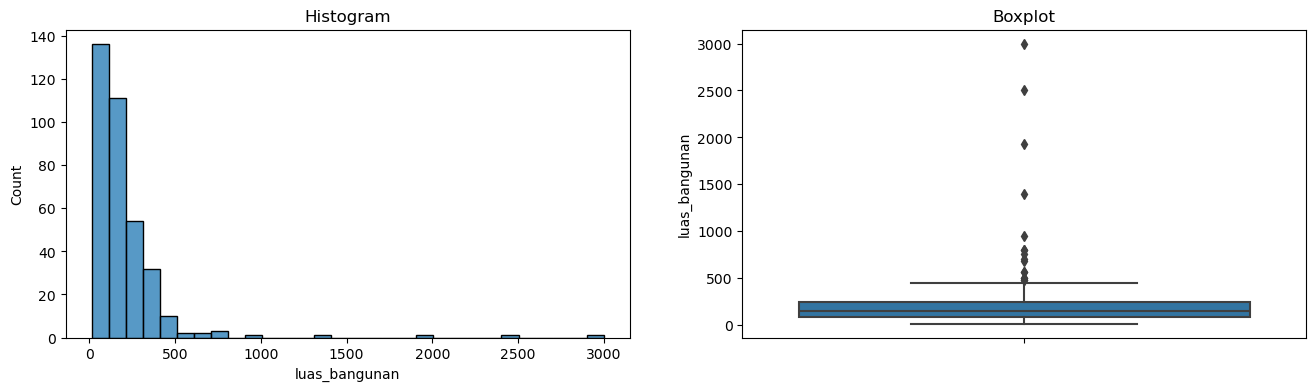


luas_bangunan - After Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


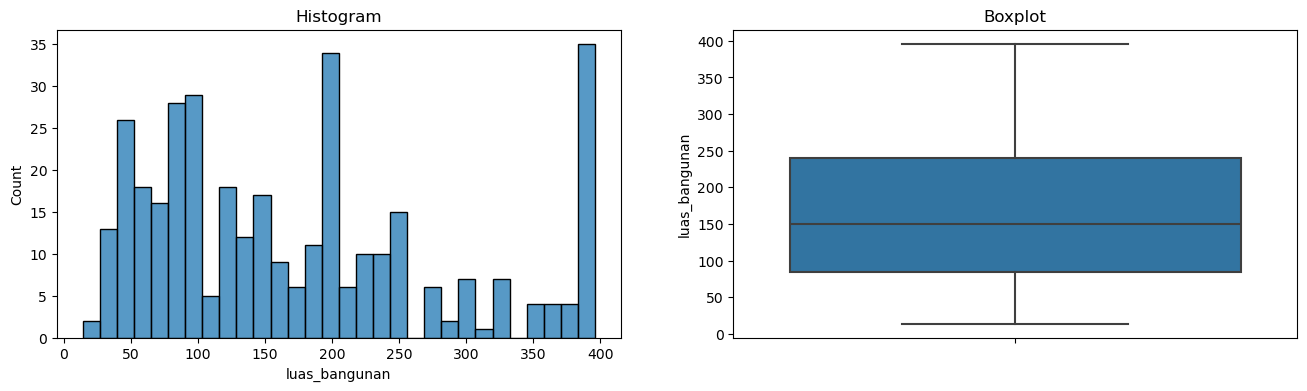

luas_tanah - Before Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


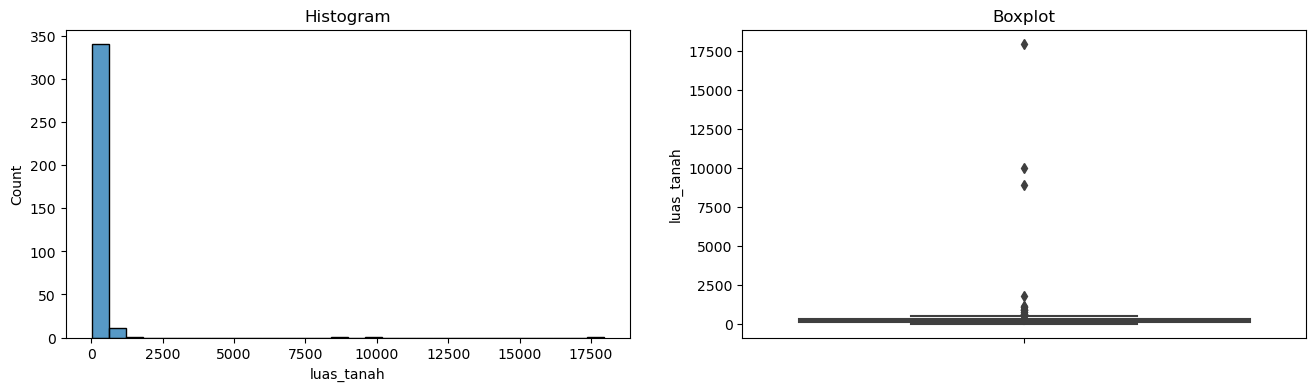


luas_tanah - After Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


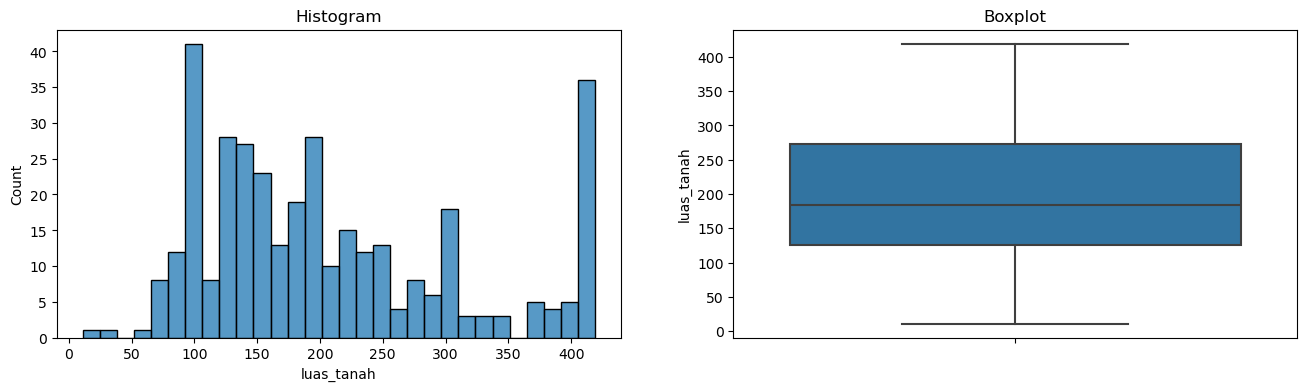

kamar_tidur - Before Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


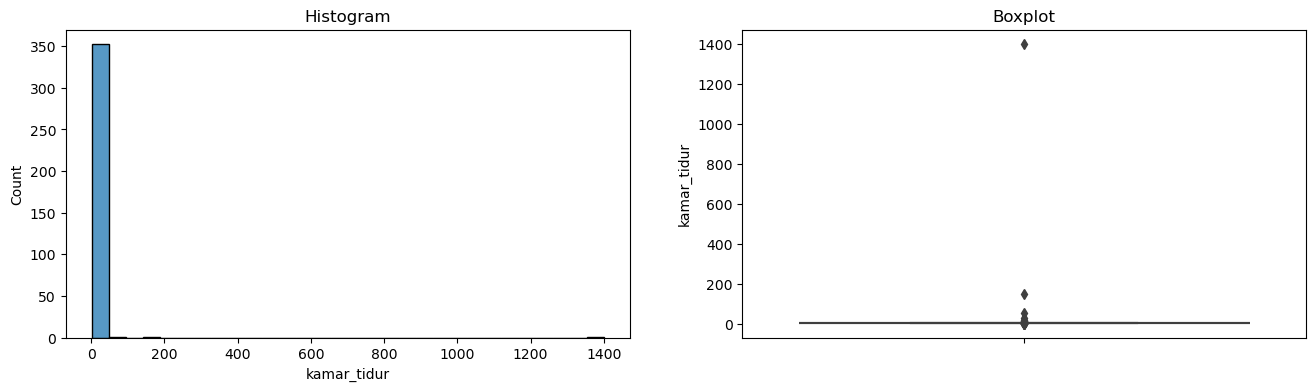


kamar_tidur - After Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


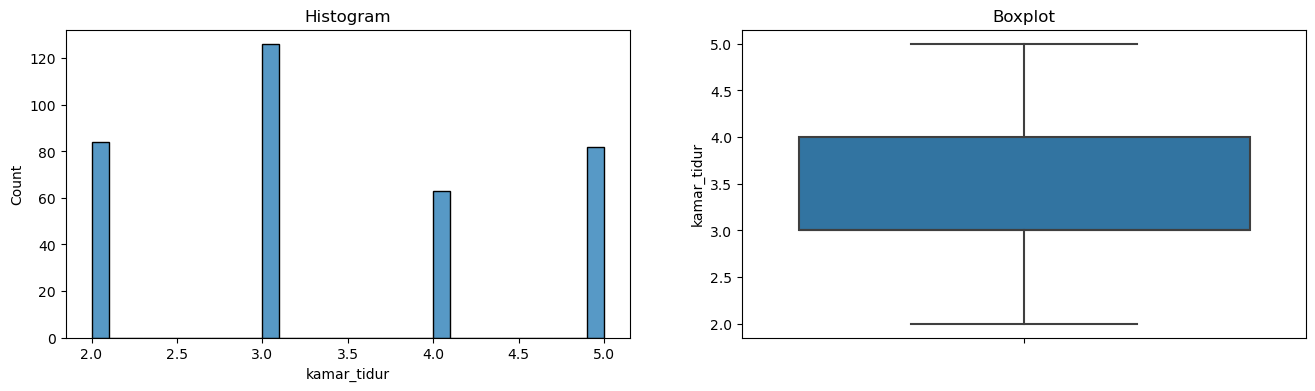

kamar_mandi - Before Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


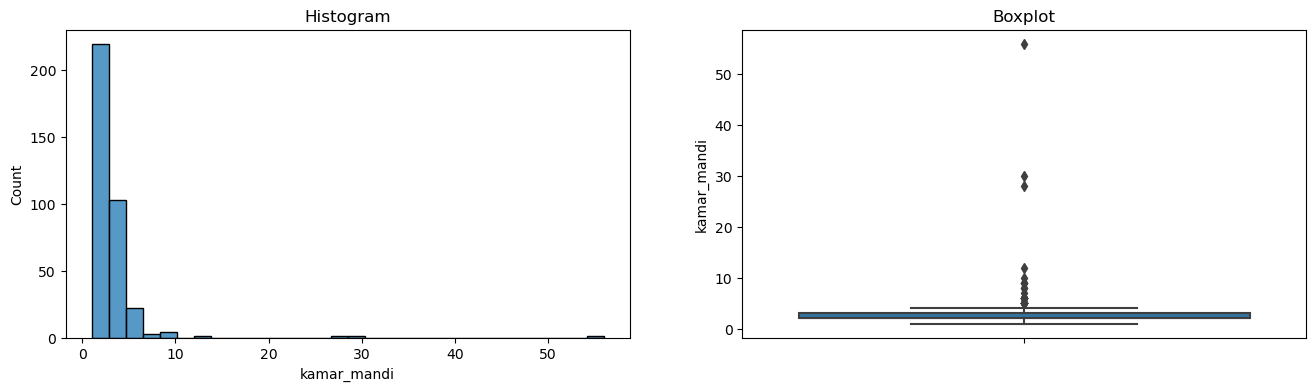


kamar_mandi - After Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


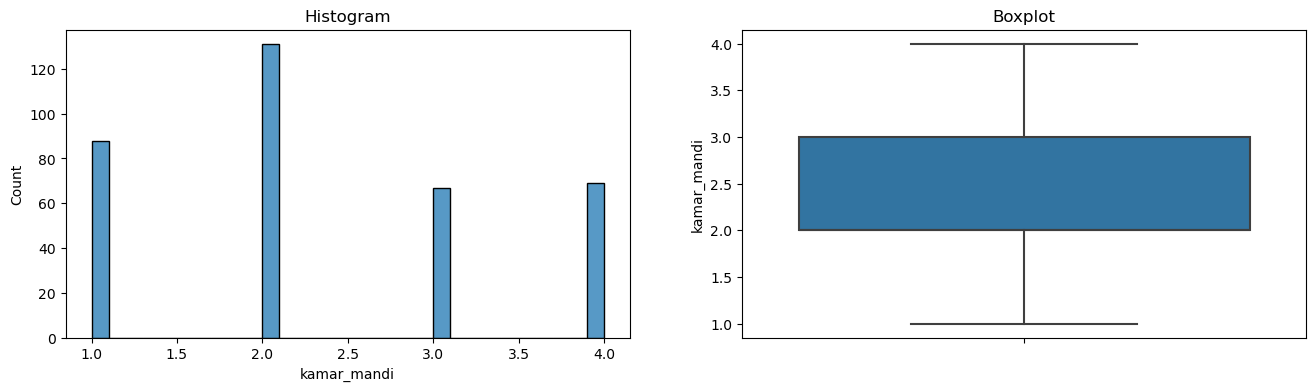

listrik - Before Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


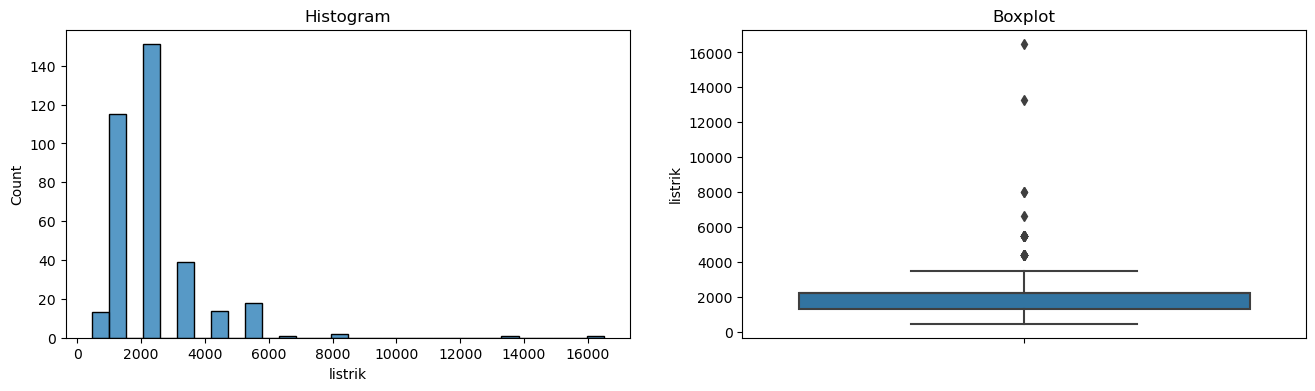


listrik - After Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


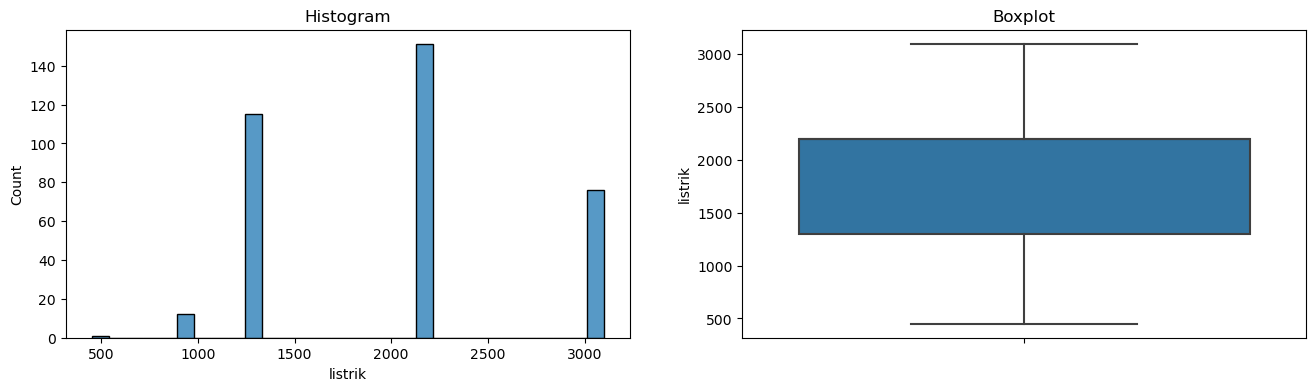

kamar_pembantu - Before Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


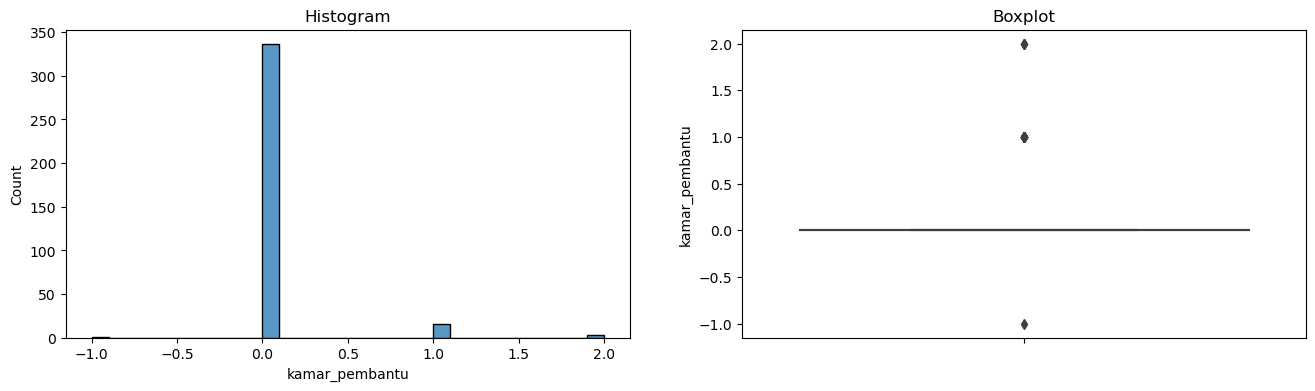


kamar_pembantu - After Capping


c:\Users\YOGA\anaconda3\envs\phase1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


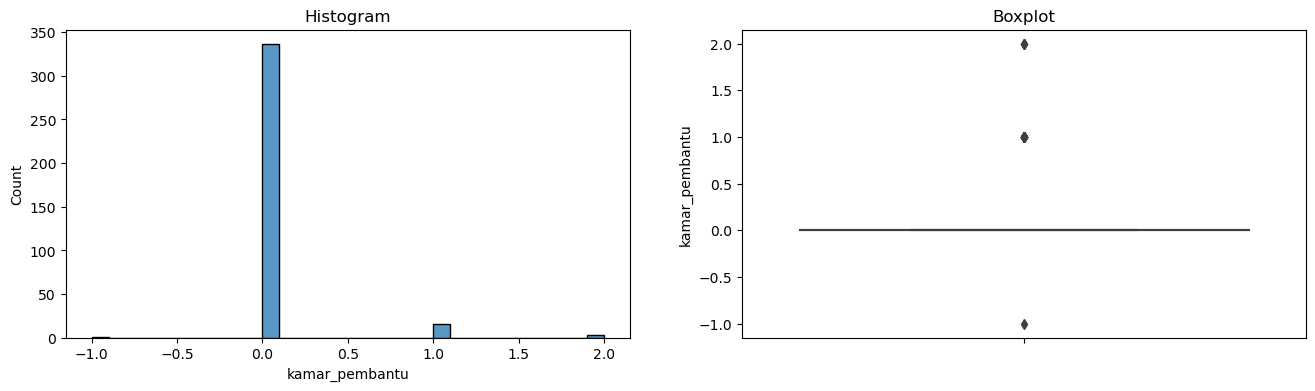

In [28]:
# Check the distribution before and after capping
for col in num_cols:
  print(f'{col} - Before Capping')
  diagnostic_plots(X_train, col)

  print(f'\n{col} - After Capping')
  diagnostic_plots(X_train_capped, col)

In [31]:
X_train_capped.isnull().sum()

lokasi            0
luas_bangunan     0
luas_tanah        0
sertifikat        0
furnish           0
kamar_tidur       0
kamar_mandi       0
listrik           0
kamar_pembantu    0
dtype: int64

In [32]:
X_test_capped.isnull().sum()

lokasi            0
luas_bangunan     0
luas_tanah        0
sertifikat        0
furnish           0
kamar_tidur       0
kamar_mandi       0
listrik           0
kamar_pembantu    0
dtype: int64

## 4.4. Split between Num Col and Cat Col

In [39]:
#Get numeric and categorical column

num_columns = X_train_capped.select_dtypes(include = np.number).columns.tolist()
cat_columns = X_train_capped.select_dtypes(include = ['object']).columns.tolist()

print('Numeric Columns: ', num_columns)
print('Categorical Columns: ', cat_columns)

Numeric Columns:  ['luas_bangunan', 'luas_tanah', 'kamar_tidur', 'kamar_mandi', 'listrik', 'kamar_pembantu']
Categorical Columns:  ['lokasi', 'sertifikat', 'furnish']


In [40]:
# Split numerical columns and categorical columns

X_train_num = X_train_capped[num_columns]
X_train_cat = X_train_capped[cat_columns]

X_test_num = X_test_capped[num_columns]
X_test_cat = X_test_capped[cat_columns]

X_train_num

,luas_bangunan,luas_tanah,kamar_tidur,kamar_mandi,listrik,kamar_pembantu
291,60.0,90.0,3,2,2200.0,0
415,380.0,400.0,5,3,3100.0,0
65,396.0,419.0,5,4,3100.0,0
435,39.0,72.0,2,1,1300.0,0
336,54.0,100.0,2,1,1300.0,0
...,...,...,...,...,...,...
306,150.0,241.0,3,3,2200.0,0
165,50.0,105.0,2,2,2200.0,0
7,128.0,225.0,3,2,1300.0,0
219,54.0,100.0,2,1,1300.0,0


In [43]:
X_train_num

,luas_bangunan,luas_tanah,kamar_tidur,kamar_mandi,listrik,kamar_pembantu
291,60.0,90.0,3,2,2200.0,0
415,380.0,400.0,5,3,3100.0,0
65,396.0,419.0,5,4,3100.0,0
435,39.0,72.0,2,1,1300.0,0
336,54.0,100.0,2,1,1300.0,0
...,...,...,...,...,...,...
306,150.0,241.0,3,3,2200.0,0
165,50.0,105.0,2,2,2200.0,0
7,128.0,225.0,3,2,1300.0,0
219,54.0,100.0,2,1,1300.0,0


In [44]:
y_train

291     800000
415    1600000
65     9300000
435     499060
336     788000
        ...   
306     900000
165     500000
7       950000
219     828000
326    2080000
Name: harga, Length: 355, dtype: int64

### 4.4.1. Feature Selection numerical columns

In [45]:
# Feature selection Numerical columns
p_values = []
interpretasi = []
cols = []

for col in X_train_num.columns:
  corr_coef, p_value = pearsonr(X_train_num[col], y_train)

  p_values.append(p_value)
  cols.append(col)

  if p_value < 0.05:
    interpretasi.append('ada korelasi')
  else :
    interpretasi.append('ga ada korelasi')

pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi})

,nama kolom,hasil
0,luas_bangunan,ada korelasi
1,luas_tanah,ada korelasi
2,kamar_tidur,ada korelasi
3,kamar_mandi,ada korelasi
4,listrik,ada korelasi
5,kamar_pembantu,ga ada korelasi


### 4.4.2. Feature Selection categorical columns

In [47]:
X_train_capped[cat_cols]

,lokasi,sertifikat,furnish
291,Sungai Pinang,SHM,Non-furnished
415,Samarinda Kota,SHM,Semi-furnished
65,Samarinda Ulu,SHM,Non-furnished
435,Loa Janan Ilir,PPJB,Non-furnished
336,Samarinda Ulu,SHM,Non-furnished
...,...,...,...
306,Samarinda Ulu,SHM,Non-furnished
165,Samarinda Kota,SHM,Non-furnished
7,Sambutan,HGB,Non-furnished
219,Sungai Kunjang,SHM,Non-furnished


Karena hanya ada 3 kolom kategorik, maka semua kolom akan digunakan menjadi fitur dalam model

## 4.4.3. Column Transformer

In [52]:
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), selector(dtype_exclude='object')),
    ('encoding', OneHotEncoder(), selector(dtype_include='object'))
])

In [75]:
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

# 5. Model Definition

In [68]:
# Define model (default hyperparameter)
models_def = {
    'Linear_Regression': LinearRegression(),
    'SVM': SVR(),
    'KNN': KNeighborsRegressor(),
    'Decision_Tree': DecisionTreeRegressor(),
    'Random_Forest': RandomForestRegressor(),
    'XGBoosting': xgb.XGBRegressor(objective='reg:squarederror')
}

# 6. Model Training

In [76]:
for model_name, model in models_def.items():
    pipeline = Pipeline(steps=[
        ('transformer', transformer),
        ('model', model)
    ])
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Calculate training and testing scores
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    
    print(f"Model: {model_name}")
    print(f"Training Score: {round(train_score, 4)}")
    print(f"Testing Score: {round(test_score, 4)}")
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    mae = -np.mean(scores)
    print(f"Cross-Validation MAE: {round(mae, 4)}\n")

Model: Linear_Regression
Training Score: 0.7675
Testing Score: 0.3448
Cross-Validation MAE: 2121425.9038

Model: SVM
Training Score: -0.0498
Testing Score: -0.0142
Cross-Validation MAE: 1777309.0619

Model: KNN
Training Score: 0.6129
Testing Score: 0.3426
Cross-Validation MAE: 1343288.6165

Model: Decision_Tree
Training Score: 0.9999
Testing Score: 0.664
Cross-Validation MAE: 1382965.903

Model: Random_Forest
Training Score: 0.9523
Testing Score: 0.574
Cross-Validation MAE: 1123922.5308

Model: XGBoosting
Training Score: 0.9998
Testing Score: 0.5971
Cross-Validation MAE: 1155835.7361



# 7. Model Evaluation

In [80]:
# Define the parameter grid
param_grid = {
    'n_estimators': [500, 1200, 1800, 2000],
    'max_depth': [9, 20, 30, 40, 50],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)

# Fit the GridSearchCV to find the best parameters
grid_search.fit(X_train_transformed, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best MAE score: ", -grid_search.best_score_)

Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}
Best MAE score:  1120900.5558724215


In [83]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                   scoring='neg_mean_absolute_error', n_iter=100, cv=5,
                                   verbose=2, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV to find the best parameters
random_search.fit(X_train_transformed, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best MAE score: ", -random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Best MAE score:  990508.6402758214


In [84]:
X_train_transformed_capped = transformer.fit_transform(X_train_capped)
X_test_transformed_capped = transformer.transform(X_test_capped)

In [85]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                   scoring='neg_mean_absolute_error', n_iter=100, cv=5,
                                   verbose=2, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV to find the best parameters
random_search.fit(X_train_transformed_capped, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best MAE score: ", -random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best MAE score:  1190647.767567221
